# Smart Water Quality Monitoring System - Clustering Analysis

In [44]:
 import tables
 import time
 import pandas as pd
 import numpy as np
 from matplotlib import pyplot
 import matplotlib.pyplot as plt 
 from matplotlib import pylab
 from pylab import rcParams
 from itertools import combinations
 import itertools
 from IPython.display import Markdown, display, HTML
 from operator import itemgetter
 from IPython.core.display import HTML
 import seaborn as sb
 from azure.storage.blob import BlockBlobService
    
 rcParams['axes.facecolor'] = 'white'
 rcParams['axes.edgecolor'] = 'black'
 rcParams['axes.linewidth'] = 1
 rcParams['figure.figsize'] = (4,4)

Disable auto-scrolling

In [45]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

Suppress warning messages

In [46]:
import sys
import time
import warnings
from IPython.display import Markdown, display

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [47]:
 from scipy import stats

#LOCALFILE is the file path    
STORAGEACCOUNTNAME= "smartwaterstorage"
STORAGEACCOUNTKEY= "5GGqEdDGjlqyKRjnLIFogG1LzeUlyQ3iwMBFyDgR7pdB4VPMtuUwvBNUyAss98wrNTWa8KNTe+L7DxMcEWyY5Q=="
LOCALFILENAME= "SW"    
CONTAINERNAME= "smart-water-db"
blob_service=BlockBlobService (account_name=STORAGEACCOUNTNAME,account_key=STORAGEACCOUNTKEY)
    
filenames = ['NoMedium', 'Tap_Water', 'Flour_Water', 'Soap_Water', 'Shampoo_Water', 'Sea_Water']
    
df_all =  pd.DataFrame()

for i, name in enumerate(filenames):
     BLOBNAME= "ModelTraining/Dataset/" + name + ".csv"
     blob_service.get_blob_to_path(CONTAINERNAME,BLOBNAME,LOCALFILENAME)   

     # Read Blob storage data
     dataframe_blobdata = pd.read_csv(LOCALFILENAME, header=0) 
     #dataframe_blobdata = pd.read_csv("Dataset/" + name + ".csv", header=0) 
    
     # Group sensor data readings by 'datetime' column   
     df_sensordata = dataframe_blobdata[['datetime','sensor','value']].groupby(['datetime','sensor']).value.first().unstack().dropna()

     # Split accelerometer reading 'ACC' column to 3-axis columns ()'ACC_X', 'ACC_Y', 'ACC_Z')   
     df_sensordata[['ACC_X', 'ACC_Y', 'ACC_Z']] = df_sensordata['ACC'].str.split(';', expand=True)

     # Convert 'BAT', 'WT', 'PH', 'DO', 'ORP', 'COND' columns to float datatype
     df_sensordata[['BAT', 'WT', 'PH', 'DO', 'ORP', 'COND']] = df_sensordata[['BAT', 'WT', 'PH', 'DO', 'ORP', 'COND']].astype(float)

     # Convert 'ACC_X', 'ACC_Y', 'ACC_Z' columns to integer datatype
     df_sensordata[['ACC_X', 'ACC_Y', 'ACC_Z']] = df_sensordata[['ACC_X', 'ACC_Y', 'ACC_Z']].astype(int)

     # Convert 'DATE' column to date datatype 
     df_sensordata['DATE'] =  pd.to_datetime(df_sensordata['DATE'], format='%y-%m-%d')

     # Convert 'TIME' column to time datatype 
     df_sensordata['TIME'] =  pd.to_datetime(df_sensordata['TIME'], format='%H-%M-%S').dt.time

     df_sensordata['DT'] = pd.to_datetime(df_sensordata.DATE.astype(str)+' '+df_sensordata.TIME.astype(str))

     # Reorder columns
     df_sensordata= df_sensordata[['ACC_X', 'ACC_Y', 'ACC_Z', 'BAT', 'WT', 'PH', 'DO', 'ORP', 'COND']]

     # Remove Outliers
     df_sensordata = df_sensordata[(np.abs(stats.zscore(df_sensordata)) < 2).all(axis=1)]

     # Reset index column   
     df_sensordata.reset_index(drop = True, inplace = True)
    
     if(i == 0):
         df_sensordata['class'] = 0
         df_all = pd.DataFrame(data=None, columns=df_sensordata.columns, index=df_sensordata.index)
         df_all = pd.concat([df_all, df_sensordata], axis=0)
     else:
         df_sensordata['class'] = int(i)
         df_all = pd.concat([df_all, df_sensordata], axis=0)

df_all = df_all.dropna()
df_all[['ACC_X', 'ACC_Y', 'ACC_Z', 'BAT', 'class']] = df_all[['ACC_X', 'ACC_Y', 'ACC_Z', 'BAT', 'class']].astype(int)

In [48]:
print('the size of the data is: %d rows and  %d columns' % df_all.shape)

the size of the data is: 967 rows and  10 columns


In [49]:
for col in df_all.columns:
     print(df_all[col].name, ':\t', df_all[col].dtype)

ACC_X :	 int64
ACC_Y :	 int64
ACC_Z :	 int64
BAT :	 int64
WT :	 float64
PH :	 float64
DO :	 float64
ORP :	 float64
COND :	 float64
class :	 int64


# 2. Clustering Analysis

## (a) Evaluate Algorithms

### (i) Select Optimal K for Clustering

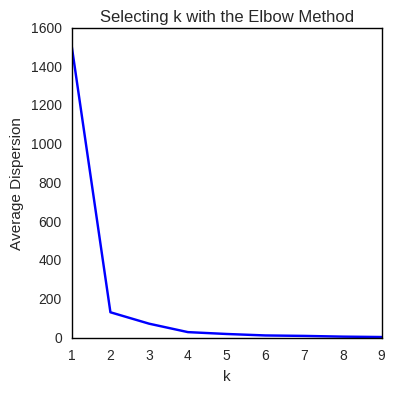

In [50]:
from sklearn.cluster import KMeans 
from scipy.spatial.distance import cdist 
from sklearn import metrics
import matplotlib.pyplot as plt
X = df_all.iloc[:,5:9]
K = range(1, 10) 
meanDispersions = [] 
for k in K: 
    kmeans = KMeans(n_clusters=k) 
    kmeans.fit(X) 
    meanDispersions.append(sum(np.min(cdist(X,kmeans.cluster_centers_,'euclidean'),axis=1))/X.shape[0])
plt.plot(K, meanDispersions, 'bx-') 
plt.xlabel('k') 
plt.ylabel('Average Dispersion') 
plt.title('Selecting k with the Elbow Method') 
plt.show()

### (ii) Evaluate Algorithm Performance

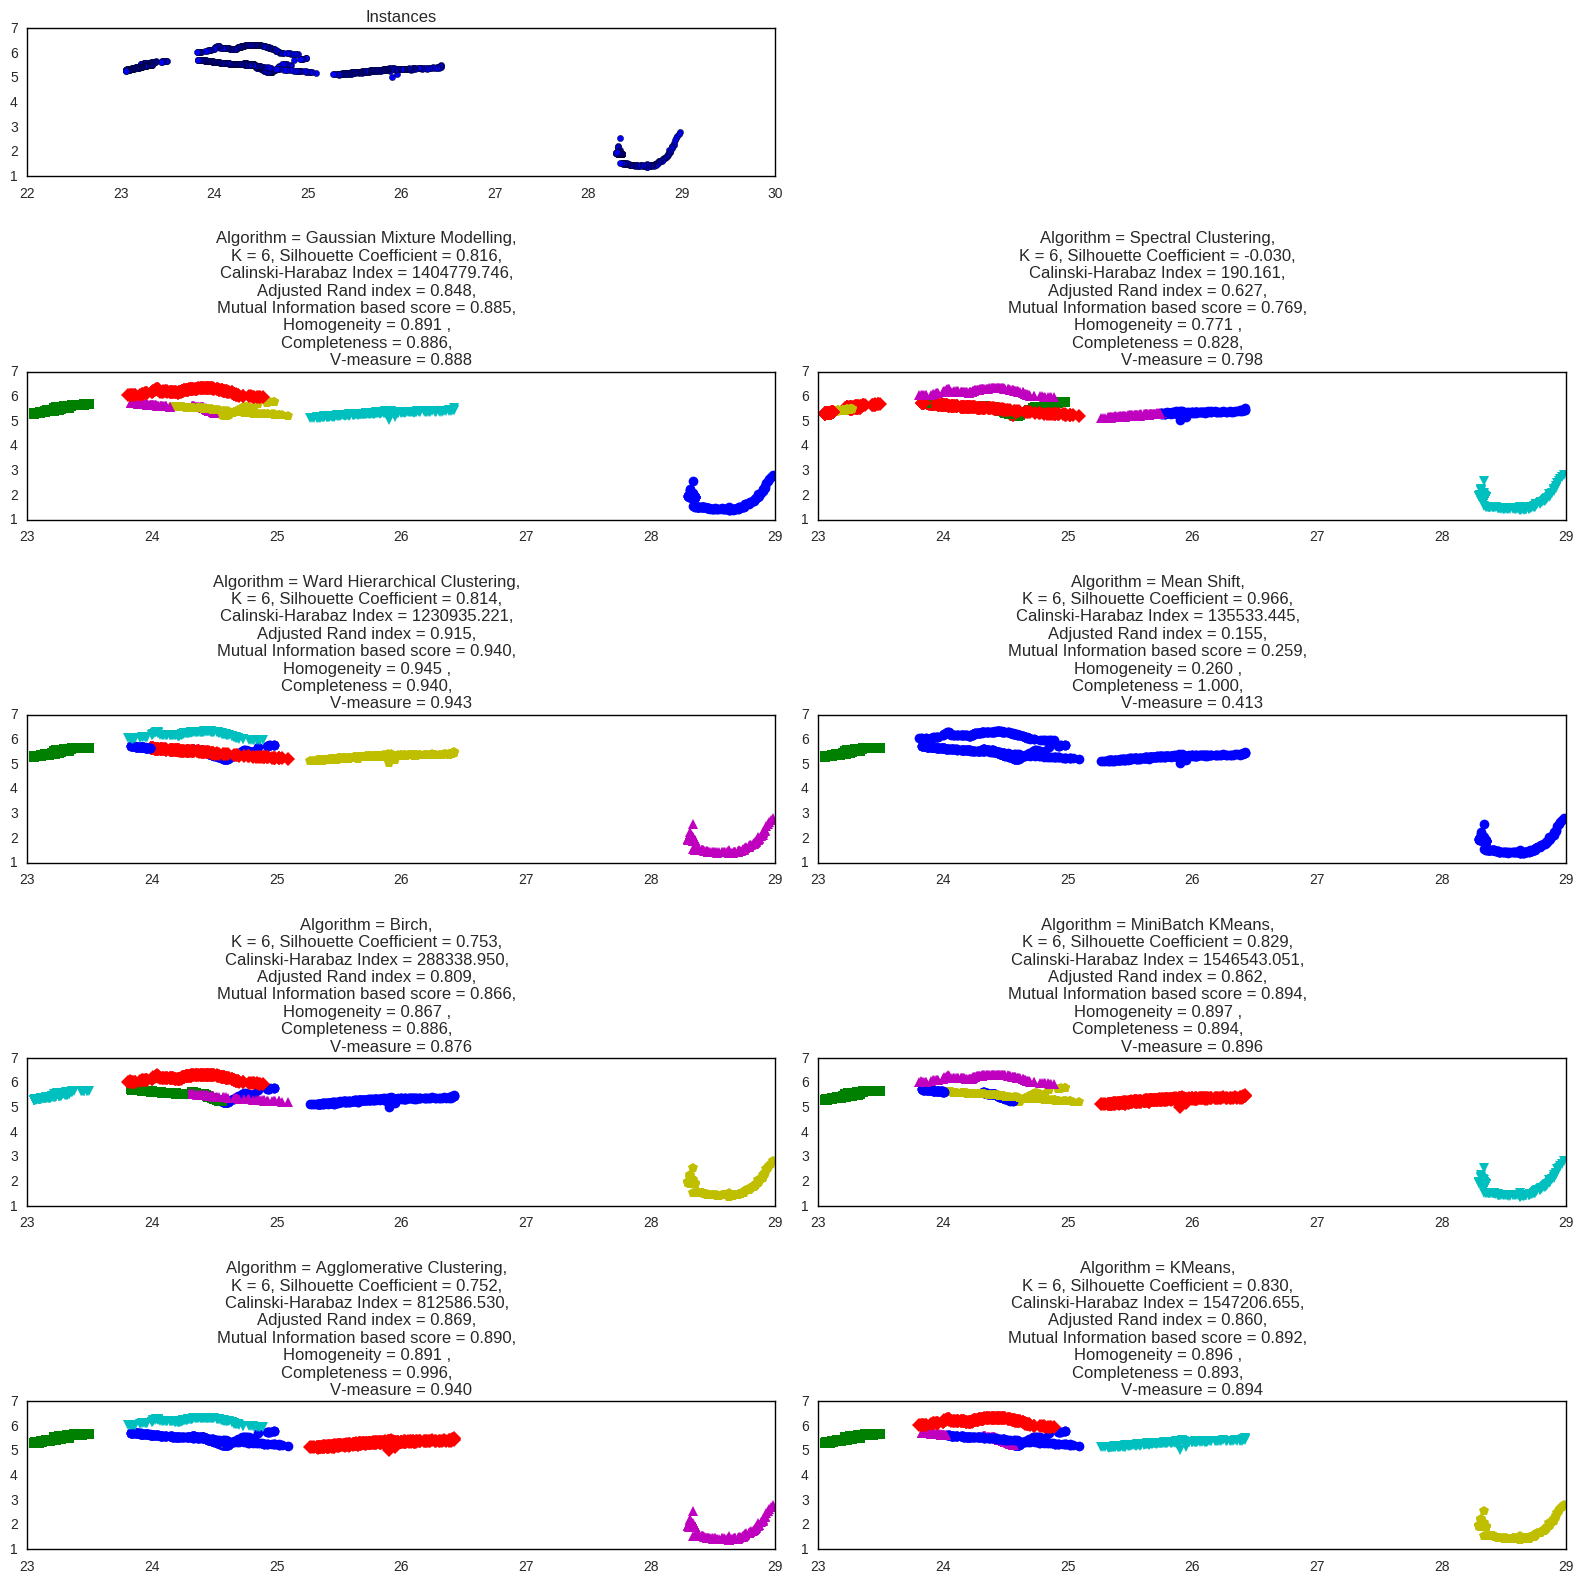

In [51]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
from sklearn.mixture import GaussianMixture
from sklearn.cluster import SpectralClustering 
from sklearn.cluster import MeanShift 
from sklearn.cluster import estimate_bandwidth 
from sklearn.cluster import MiniBatchKMeans 
from sklearn.cluster import Birch
from sklearn import metrics
import matplotlib.pyplot as plt

t = 6

X_features = df_all[['WT', 'PH', 'DO', 'ORP', 'COND']]
x1 = df_all["WT"].values
x2 = df_all["PH"].values
labels_true = df_all["class"].values

score_list = []

# connectivity matrix for structured Ward
connectivity = kneighbors_graph(X_features, n_neighbors=10, include_self=False)
# make connectivity symmetric
connectivity = 0.5 * (connectivity + connectivity.T)

fig = plt.figure(figsize=(16,16))

plt.subplot(5, 2, 1)
plt.title('Instances')
plt.scatter(x1, x2)

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'b']
markers = ['o', 's', 'D', 'v', '^', 'p', '*', '+']

Kclasses_KMeans = []
classifiers = {'KMeans' : KMeans(n_clusters=t, n_init=30, max_iter=500),
           'Ward Hierarchical Clustering' : AgglomerativeClustering(n_clusters=t, affinity = 'euclidean', linkage = 'ward', connectivity=connectivity, compute_full_tree='auto'), 
           'Gaussian Mixture Modelling' : GaussianMixture(n_components=t,init_params='kmeans'),
           'Spectral Clustering' : SpectralClustering(n_clusters=t, eigen_solver='arpack',affinity="nearest_neighbors"),
           'Mean Shift' : MeanShift(),
           'MiniBatch KMeans' : MiniBatchKMeans(n_clusters=t),
           'Birch' : Birch(n_clusters=t),
           'Agglomerative Clustering' :  AgglomerativeClustering(linkage="average", affinity="cityblock",n_clusters=t, connectivity=connectivity) 
          }

Kclass = []
Kclasses = []
names = []

subplot_counter = 2
for i, (name, algo) in enumerate(classifiers.items()):
    subplot_counter += 1
    plt.subplot(5, 2, subplot_counter)
    Kclass = []
    model = algo
    names.append(name)
    if((name == 'Ward Hierarchical Clustering') or (name == 'Agglomerative Clustering')):
        clust_labels = model.fit_predict(X_features)
    elif(name == 'Gaussian Mixture Modelling'):
        model.fit(X_features) 
        clust_labels = model.predict(X_features)
    else: 
        model.fit(X_features)
        clust_labels = model.labels_
       
    for i, l in enumerate(clust_labels):
        Kclass.append(l)
        plt.plot(x1[i], x2[i], color=colors[l], marker=markers[l], ls='None') 
    Kclasses.append(Kclass)
    plt.title('Algorithm = %s, \
              \nK = %s, Silhouette Coefficient = %.03f, \
              \nCalinski-Harabaz Index = %.03f, \
              \nAdjusted Rand index = %.03f, \
              \nMutual Information based score = %.03f, \
              \nHomogeneity = %.03f , \
              \nCompleteness = %.03f, \
              \nV-measure = %.03f' % ( \
              name, \
              t, \
              metrics.silhouette_score(X_features, clust_labels, metric='euclidean'), \
              metrics.calinski_harabaz_score(X_features, clust_labels), \
              metrics.adjusted_rand_score(labels_true, clust_labels), \
              metrics.adjusted_mutual_info_score(clust_labels, labels_true), \
              metrics.homogeneity_score(labels_true, clust_labels), \
              metrics.completeness_score(labels_true, clust_labels), \
              metrics.v_measure_score(labels_true, clust_labels)))
    score_list.append([name, 
                      metrics.silhouette_score(X_features, clust_labels, metric='euclidean'),
                      metrics.calinski_harabaz_score(X_features, clust_labels),
                      metrics.adjusted_rand_score(labels_true, clust_labels),
                      metrics.adjusted_mutual_info_score(clust_labels, labels_true),
                      metrics.homogeneity_score(labels_true, clust_labels),
                      metrics.completeness_score(labels_true, clust_labels),
                      metrics.v_measure_score(labels_true, clust_labels)])
    plt.tight_layout()
plt.show()

From the charts above, it can be observed that for Ward Hierarchical Clustering algorithm shows the least overlap between the identified clusters 

### (iii) Compare Clustering Results

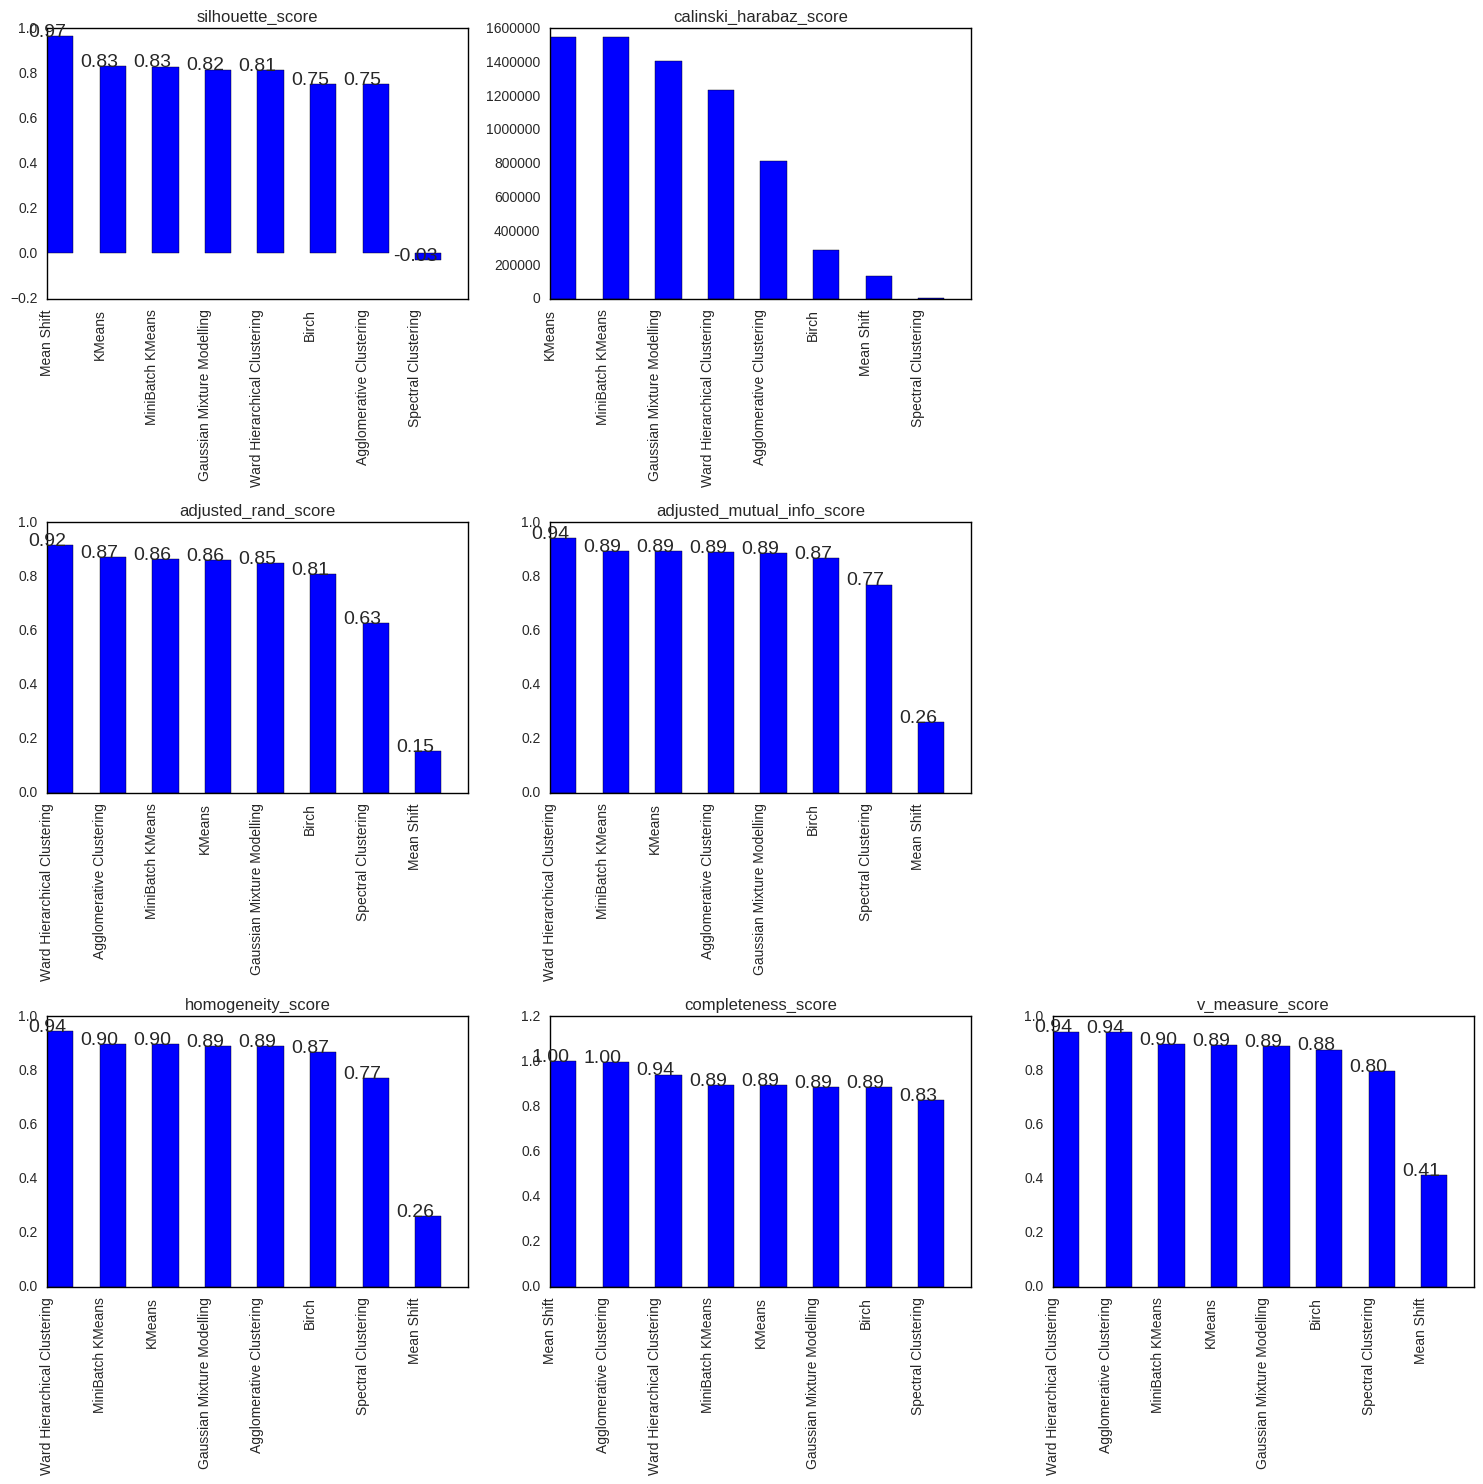

In [52]:
def plot_scores(score_list):      
    score_list.sort(key=lambda x: -x[1])
    names = list([item[0] for item in score_list])
    silhouette_scores = list([item[1] for item in score_list])
    calinski_harabaz_scores = list([item[2] for item in score_list])
    adjusted_rand_scores = list([item[3] for item in score_list])
    adjusted_mutual_info_scores = list([item[4] for item in score_list])
    homogeneity_scores = list([item[5] for item in score_list])  
    completeness_scores = list([item[6] for item in score_list])  
    v_measure_scores = list([item[7] for item in score_list])  
    idx = [i for i, _ in enumerate(names)]

    pyplot.rcParams['figure.figsize'] = [15, 15]
    
    PltNames = ['silhouette_score',
                'calinski_harabaz_score',
                'adjusted_rand_score',
                'adjusted_mutual_info_score',
                'homogeneity_score',
                'completeness_score',
                'v_measure_score']
    PltVars = [silhouette_scores, calinski_harabaz_scores, adjusted_rand_scores, adjusted_mutual_info_scores, 
               homogeneity_scores, completeness_scores, v_measure_scores]
    
    for i in range(0,7):
        if(i>=4):
            plt.subplot(3,3,i+3)       
        elif(i>=2):
            plt.subplot(3,3,i+2) 
        else:
            plt.subplot(3,3,i+1) 

        plt.title(PltNames[i])
        indices, L_sorted = zip(*sorted(enumerate(PltVars[i]), key=itemgetter(1), reverse=True))
        names_sorted = [names[i] for i in list(indices)]
        plt.bar(range(len(names_sorted)),list(L_sorted), color = 'b', width = 0.5)
        
        if(i!=1):
            for a,b in zip(range(len(names_sorted)), list(L_sorted)):
                plt.text(a, b, '{0:.2f}'.format(b), horizontalalignment='center', fontsize=14)
        plt.xticks(range(len(names_sorted)), names_sorted, rotation=90)
    plt.tight_layout()
    plt.show()
    
plot_scores(score_list)

From the charts above, it can be observed that Ward Hierarchical Clustering outperforms in 4 out of 5 performance measures (adjusted rand, adjusted mutual info, homogeneity and v_measure scores) when evaluated against the ground truth labels defined as "class" attribute in the dataset.

The silhouette and calinski harabaz scores are taken as references as these are performance measures where ground truth labels are not available, which is not the case here.

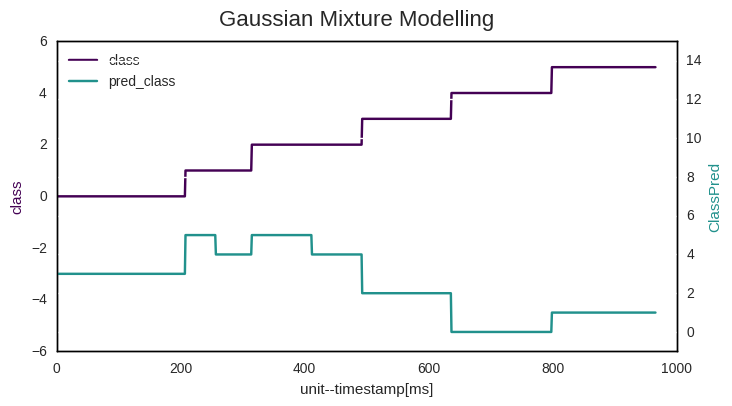

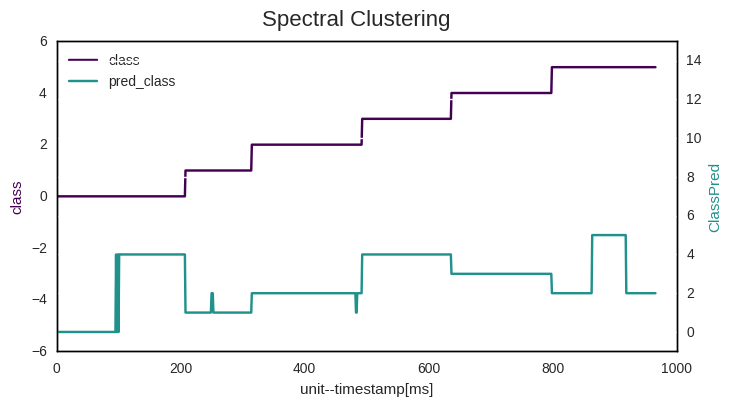

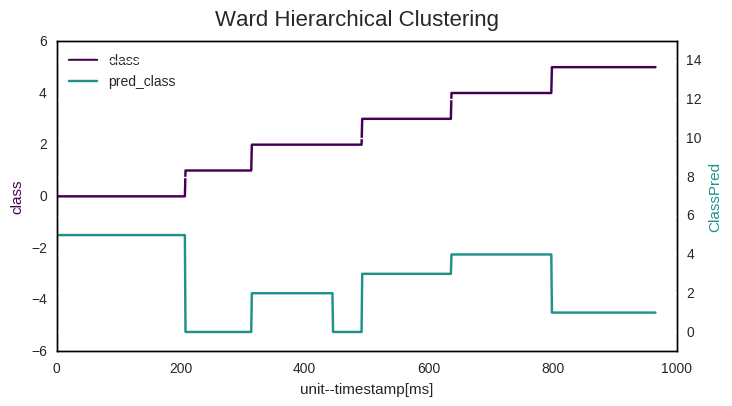

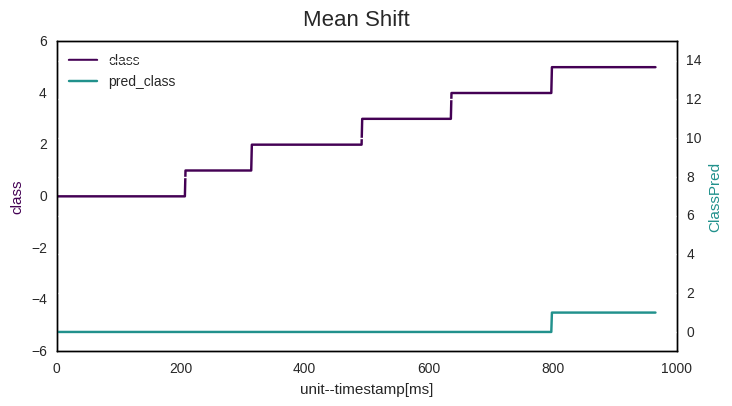

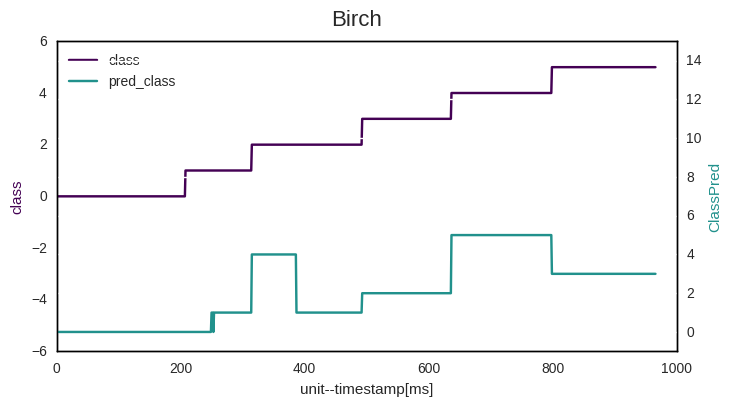

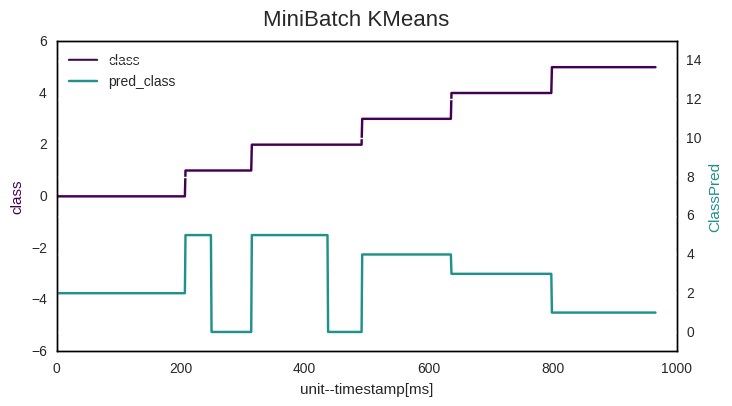

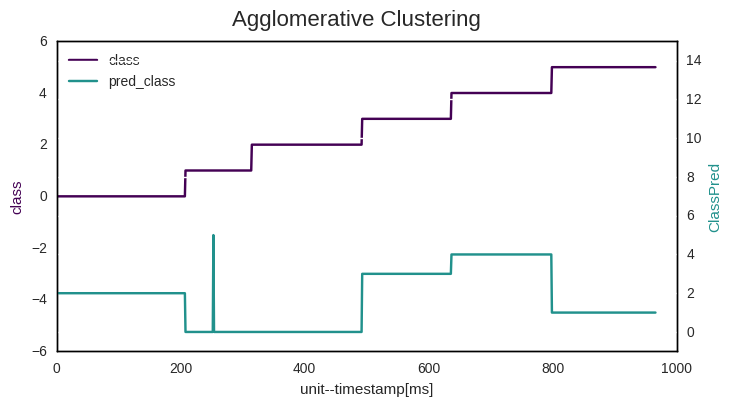

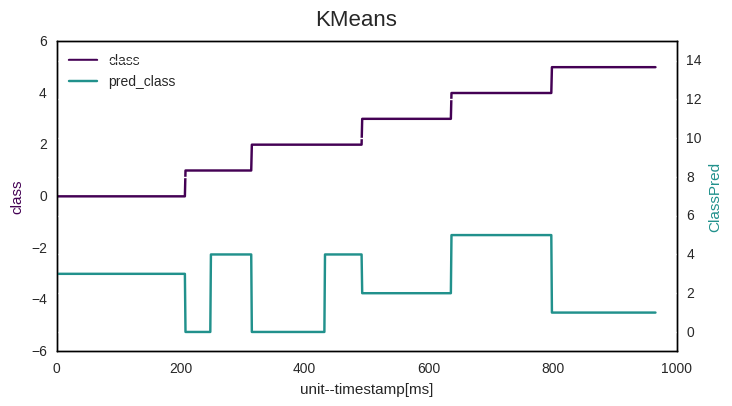

In [53]:
import matplotlib.pyplot as plt 

df_sensordata_clust = df_all

for i, KClasses_i in enumerate(Kclasses):
    se = pd.Series(KClasses_i)
    df_all['ClassPred'] = se.values
    df_sensordata_clust[names[i]] = se.values
    
    x1 = df_all["class"].values
    x2 = df_all["ClassPred"].values
    x3 = list(range(len(df_all.index)))
    fig = plt.figure(figsize=(8,4))
    host = fig.add_subplot(111)

    plt.suptitle(names[i], fontsize=16)

    par1 = host.twinx()

    host.set_ylim(-6, 6)
    par1.set_ylim(-1, 15)

    host.set_xlabel("unit--timestamp[ms]")
    host.set_ylabel("class")
    par1.set_ylabel("ClassPred")

    color1 = plt.cm.viridis(0)
    color2 = plt.cm.viridis(0.5)
    color3 = plt.cm.viridis(.9)

    p1, = host.plot(x3, x1, color=color1,label="class")
    p2, = par1.plot(x3, x2, color=color2, label="pred_class")

    lns = [p1, p2]
    host.legend(handles=lns, loc='best')

    host.yaxis.label.set_color(p1.get_color())
    par1.yaxis.label.set_color(p2.get_color())

    plt.show()
    
df_sensordata_clust.to_csv("SensorData_clustered.csv", encoding='utf-8', index=False)

From the charts above, it can be observed that the clusters identified using Ward Hierarchical Clustering algorithm closely matches that of the actual classes in the dataset except for class "2" where there is slight overlap with class "1".

For other clustering algorithms, the clusters identified by each did not match as well.

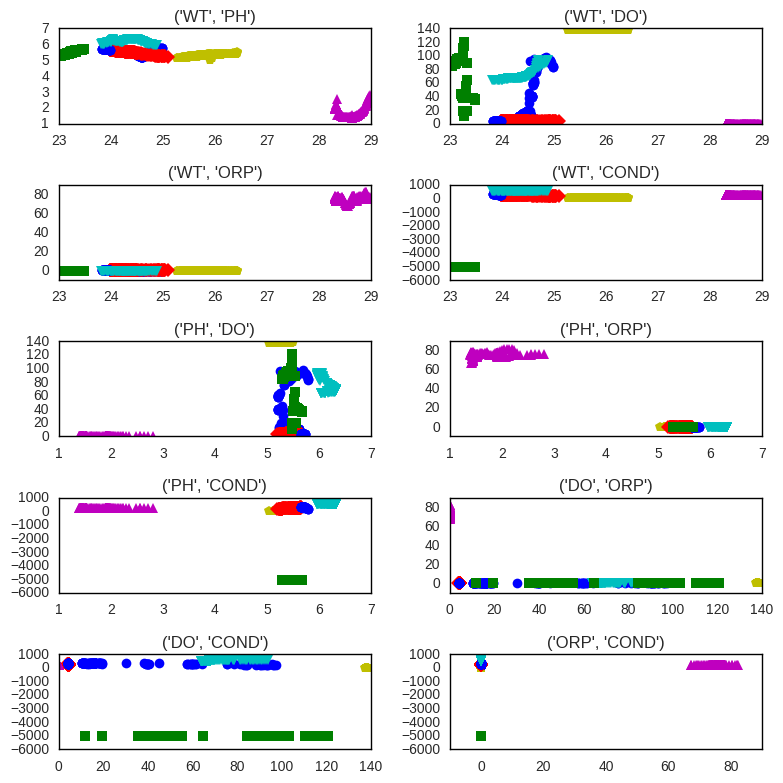

In [56]:
model = AgglomerativeClustering(n_clusters=t, affinity = 'euclidean', linkage = 'ward', connectivity=connectivity, compute_full_tree='auto')
clust_labels = model.fit_predict(X_features)

lst = [df_all["WT"].values, df_all["PH"].values, df_all["DO"].values, df_all["ORP"].values, df_all["COND"].values]
lst2 = ['WT', 'PH', 'DO', 'ORP', 'COND']

b = list(combinations(lst2, 2))

plt.figure(figsize=(8,8))

for i, combo in enumerate(combinations(lst, 2)):
    plt.subplot(5, 2, i+1)
    plt.title(b[i])
    for j, l in enumerate(clust_labels):
        plt.plot(combo[0][j], combo[1][j], color=colors[l], marker=markers[l], ls='None') 
    plt.tight_layout()
plt.show()

The scatter charts of each feature combination superimposed with cluster information identified by the Ward Hierarchical Clustering algoithm shows fairly clear identification of the different clusters identified.

__Conclusion__:

From the analysis above, it can be concluded that Ward Hierarchical Clustering algorithm performs best in identifying the different classes in the dataset as compared to other clustering algorithms. However, as there is potential overlap when identifying class "1" and "2" data, other methods of classification e.g. multi-class classification should be investigated.